- [17.2 - Robust Linear Regression](#17.2---Robust-Linear-Regression)
- [17.3 - Hierarchical Regression on Individuals within Groups](#17.3---Hierarchical-Regression-on-Individuals-within-Groups)

## Chapter 17 - Metric Predicted Variable with One Metric Predictor

In [2]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from sklearn import preprocessing
from scipy.stats import mode, norm, t
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
burnin = 25

f_dict = {'size':16}

In [3]:
# Below function takes an array as input.

def plot_posterior(dist, decimals=3, vert_ref=None, alpha=0.05, y_labels=False, ax=None):
       
    color = '#87ceeb'
    
    if ax == None:
        ax = plt.gca()
    
    ax_mode = mode(np.round(dist, decimals=decimals))[0][0] 
    hpd_interval = np.round(pmc.hpd(dist, alpha=alpha), decimals=decimals)

    # Histogram, Mode
    sns.distplot(dist, kde=False, color=color, ax=ax)
    plot_height = ax.get_ylim()[1]
    ax.text(ax_mode, plot_height*.9, 'mode = {}'.format(ax_mode),
            horizontalalignment='center', fontdict={'size':14})    

    # HPD interval
    ax.hlines(ax.get_ylim()[1]*0.01, *hpd_interval, linewidth=4)
    for interval_point in hpd_interval:
        ax.text(interval_point, plot_height*0.05, interval_point,
                horizontalalignment='center', fontdict={'size':14})
    ax.text(np.mean(hpd_interval), plot_height*0.13, '{}% HPD'.format((1-alpha)*100),
            horizontalalignment='center', fontdict={'size':14})

    # Reference line
    if vert_ref is None:
        ax.axvline(ax_mode, color='g', linestyle='dotted')
    else:
        ax.axvline(vert_ref, color='g', linestyle='dotted')

    # Set labels and axis
    if y_labels is False:
        ax.yaxis.set_visible(False)
        ax.spines['left'].set_visible(False)
    [ax.spines[spine].set_visible(False) for spine in ['right', 'top']]
    
    return(ax)

In [4]:
# Below function creates plots like 17.3 and 17.4.

def plot_grid(trace, burnin, data, sd_h, sd_w, mean_h, mean_w):
    plt.figure(figsize=(13,15))

    # Define gridspec
    gs = gridspec.GridSpec(4, 6)
    ax1 = plt.subplot(gs[:2,1:5])
    ax2 = plt.subplot(gs[2,:2])
    ax3 = plt.subplot(gs[2,2:4])
    ax4 = plt.subplot(gs[2,4:6])
    ax5 = plt.subplot(gs[3,:2])
    ax6 = plt.subplot(gs[3,2:4])                     
    ax7 = plt.subplot(gs[3,4:6])

    # Scatter plot observed data
    ax1.scatter(data.height, data.weight, s=30, linewidths=1, facecolor='none')
    ax1.set_xlabel('height', fontdict=f_dict)
    ax1.set_ylabel('height', fontdict=f_dict)
    ax1.set(xlim=(0,80), ylim=(-350,250))

    # Intercept
    plot_posterior(trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h, ax=ax2)

    # Slope
    plot_posterior(trace['beta1'][burnin:]*(sd_w/sd_h), ax=ax3)

    # Scatter plot beta1, beta0
    ax4.scatter(trace['beta1'][burnin:]*(sd_w/sd_h),
                trace['beta0'][burnin:]*sd_w+mean_w-trace['beta1'][burnin:]*mean_h*sd_w/sd_h,
               edgecolor=color, facecolor='none', alpha=.6)

    # Scale
    plot_posterior(trace['sigma'][burnin:]*sd_w, ax=ax5)

    # Normality
    plot_posterior(np.log10(trace['nu'][burnin:]), ax=ax6)

    # Scatter plot normality, sigma
    ax7.scatter(np.log10(trace['nu'][burnin:]), trace['sigma'][burnin:]*sd_w,
                edgecolor=color, facecolor='none', alpha=.6)

    plt.tight_layout()
    
    return(plt.gca());


### 17.2 - Robust Linear Regression
#### Data
#### n = 30

In [14]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
male      30 non-null int64
height    30 non-null float64
weight    30 non-null float64
dtypes: float64(2), int64(1)
memory usage: 800.0 bytes


In [15]:
df_n30.head()

   male  height  weight
0     0    64.0   136.4
1     0    62.3   215.1
2     1    67.9   173.6
3     0    64.2   117.3
4     0    64.8   123.3

In [16]:
# Using Scikit-learn to standardize the data.
# The StandardScaler objects will have the attributes scale_ and mean_ which we can 
# use to transform the model parameter back to original scale.

scaler_h = preprocessing.StandardScaler().fit(df_n30.height.reshape(-1,1))
zheight = scaler_h.transform(df_n30.height.reshape(-1,1))
sd_h = scaler_h.scale_
mean_h = scaler_h.mean_

scaler_w = preprocessing.StandardScaler().fit(df_n30.weight.reshape(-1,1))
zweight = scaler_w.transform(df_n30.weight.reshape(-1,1))
sd_w = scaler_w.scale_
mean_w = scaler_w.mean_

#### n = 300 

In [17]:
df_n300 = pd.read_csv('data/HtWtData300.csv')
df_n300.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
male      300 non-null int64
height    300 non-null float64
weight    300 non-null float64
dtypes: float64(2), int64(1)
memory usage: 7.1 KB


In [18]:
scaler_h2 = preprocessing.StandardScaler().fit(df_n300.height.reshape(-1,1))
zheight2 = scaler_h.transform(df_n300.height.reshape(-1,1))
sd_h2 = scaler_h2.scale_
mean_h2 = scaler_h2.mean_

scaler_w2 = preprocessing.StandardScaler().fit(df_n300.weight.reshape(-1,1))
zweight2 = scaler_w2.transform(df_n300.weight.reshape(-1,1))
sd_w2 = scaler_w2.scale_
mean_w2 = scaler_w2.mean_

#### N = 30
#### Model (Kruschke, 2015)

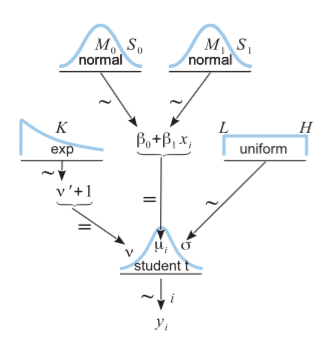

In [246]:
Image('images/fig17_2.png', width=400)

In [11]:
with pmc.Model() as model:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight.ravel()
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight.ravel())

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [25]:
with model:
    trace = pmc.sample(10000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 10000 of 10000 complete in 406.1 sec

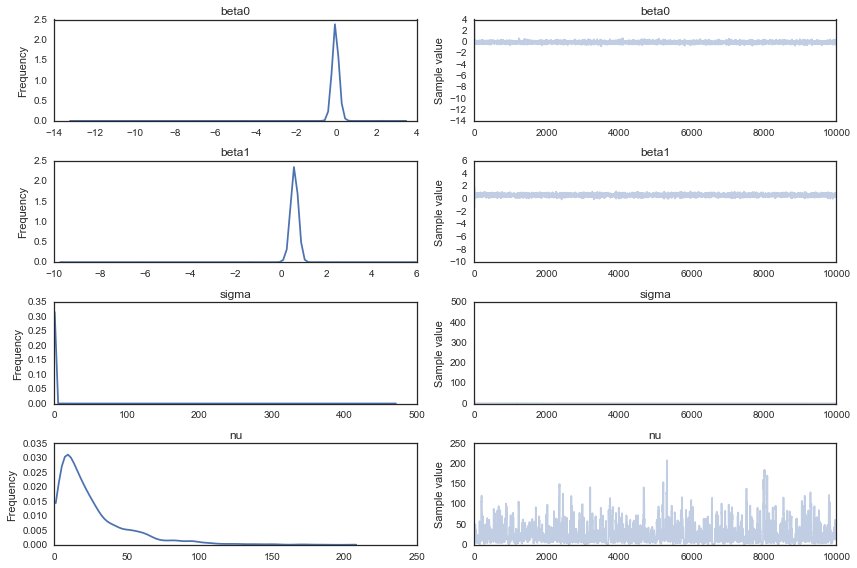

In [26]:
pmc.traceplot(trace);

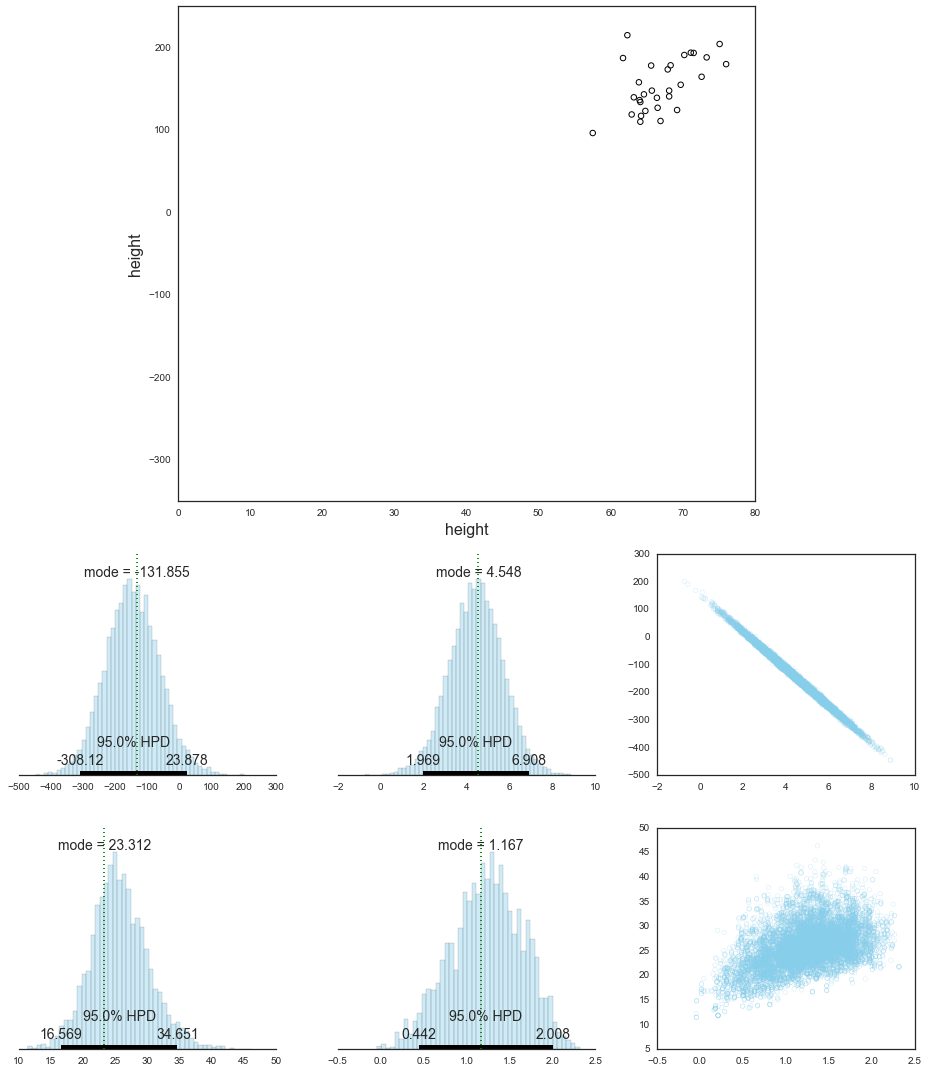

In [55]:
plot_grid(trace, 200, df_n30, sd_h, sd_w, mean_h, mean_w);

#### N = 300
#### Model

In [43]:
with pmc.Model() as model2:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    mu =  beta0 + beta1*zheight2.ravel()
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu, sd=sigma, observed=zweight2.ravel())    

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [44]:
with model2:
    trace2 = pmc.sample(10000)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------100%-----------------] 10001 of 10000 complete in 1212.5 sec

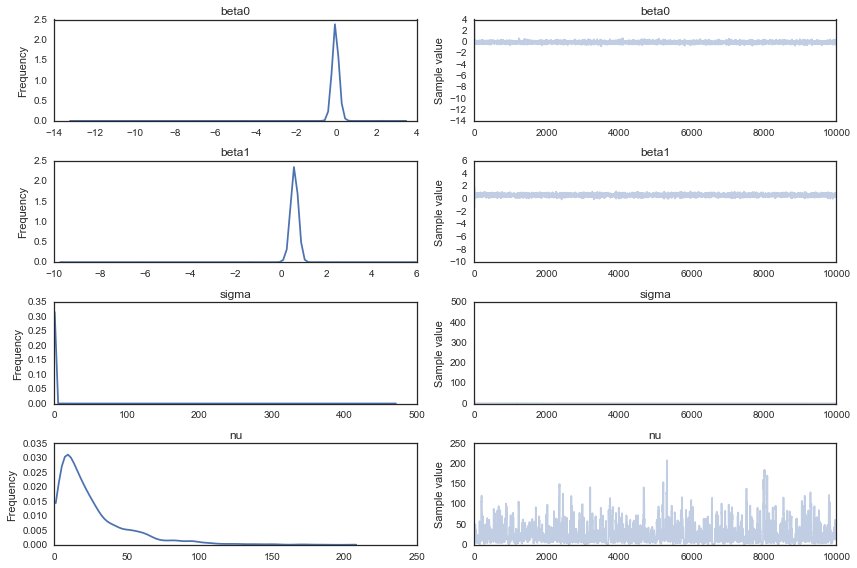

In [46]:
pmc.traceplot(trace);

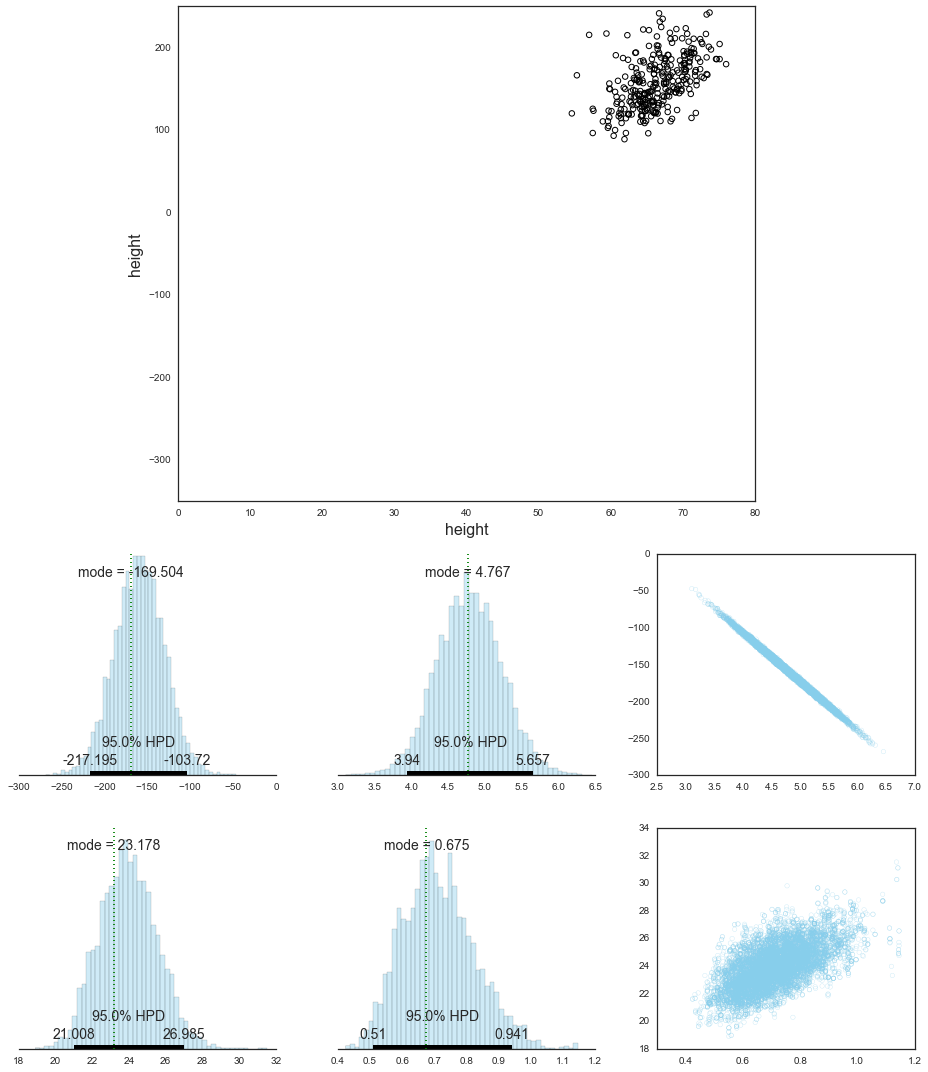

In [54]:
plot_grid(trace2, 200, df_n300, sd_h2, sd_w2, mean_h2, mean_w2);

### 17.3 - Hierarchical Regression on Individuals within Groups

In [19]:
df_HRegr = pd.read_csv('data/HierLinRegressData.csv')
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
Subj    132 non-null int64
X       132 non-null float64
Y       132 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [20]:
df_HRegr.head()

   Subj     X      Y
0     1  60.2  145.6
1     1  61.5  157.3
2     1  61.7  165.6
3     1  62.3  158.8
4     1  67.6  196.1

In [9]:
le = preprocessing.LabelEncoder()
subj_idx = le.fit_transform(df_HRegr.Subj)
subj_codes = le.classes_
n_subj = len(le.classes_)

print('Number of groups: {}'.format(n_subj))

Number of groups: 25


In [22]:
scaler_x = preprocessing.StandardScaler().fit(df_HRegr.X.reshape(-1,1))
zx = scaler_x.transform(df_HRegr.X.reshape(-1,1))
sd_x = scaler_x.scale_
mean_x = scaler_x.mean_

scaler_y = preprocessing.StandardScaler().fit(df_HRegr.Y.reshape(-1,1))
zy = scaler_y.transform(df_HRegr.Y.reshape(-1,1))
sd_y = scaler_y.scale_
mean_y = scaler_y.mean_

#### Model (Kruschke, 2015)

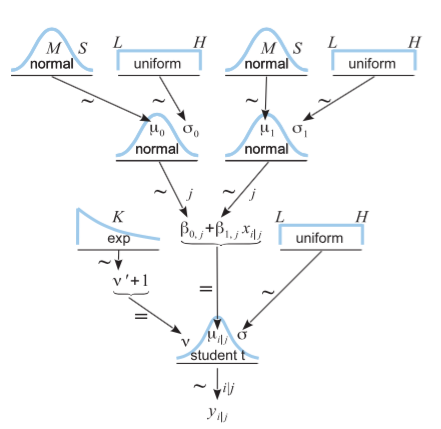

In [250]:
Image('images/fig17_6.png', width=500)

In [23]:
with pmc.Model() as model3:
    
    beta0 = pmc.Normal('beta0', mu=0, tau=1/10**2)
    beta1 = pmc.Normal('beta1', mu=0, tau=1/10**2)
    
    sigma0 = pmc.Uniform('sigma0', 10**-3, 10**3)
    sigma1 = pmc.Uniform('sigma1', 10**-3, 10**3)
    
    beta0_s = pmc.Normal('beta0_s', mu=beta0, sd=sigma0, shape=n_subj)
    beta1_s = pmc.Normal('beta1_s', mu=beta1, sd=sigma1, shape=n_subj)
    
    mu =  beta0_s[subj_idx] + beta1_s[subj_idx] * zx
    
    sigma = pmc.Uniform('sigma', 10**-3, 10**3)
    nu = pmc.Exponential('nu', 1/29.)
    
    likelihood = pmc.StudentT('likelihood', nu, mu=mu[subj_idx], sd=sigma, observed=zy)    

Applied interval-transform to sigma0 and added transformed sigma0_interval_ to model.
Applied interval-transform to sigma1 and added transformed sigma1_interval_ to model.
Applied interval-transform to sigma and added transformed sigma_interval_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [24]:
with model3:
    trace3 = pmc.sample(1500)

Assigned NUTS to beta0
Assigned NUTS to beta1
Assigned NUTS to sigma0_interval_
Assigned NUTS to sigma1_interval_
Assigned NUTS to beta0_s
Assigned NUTS to beta1_s
Assigned NUTS to sigma_interval_
Assigned NUTS to nu_log_
 [-----------------84%------------      ] 1274 of 1500 complete in 971.8 sec

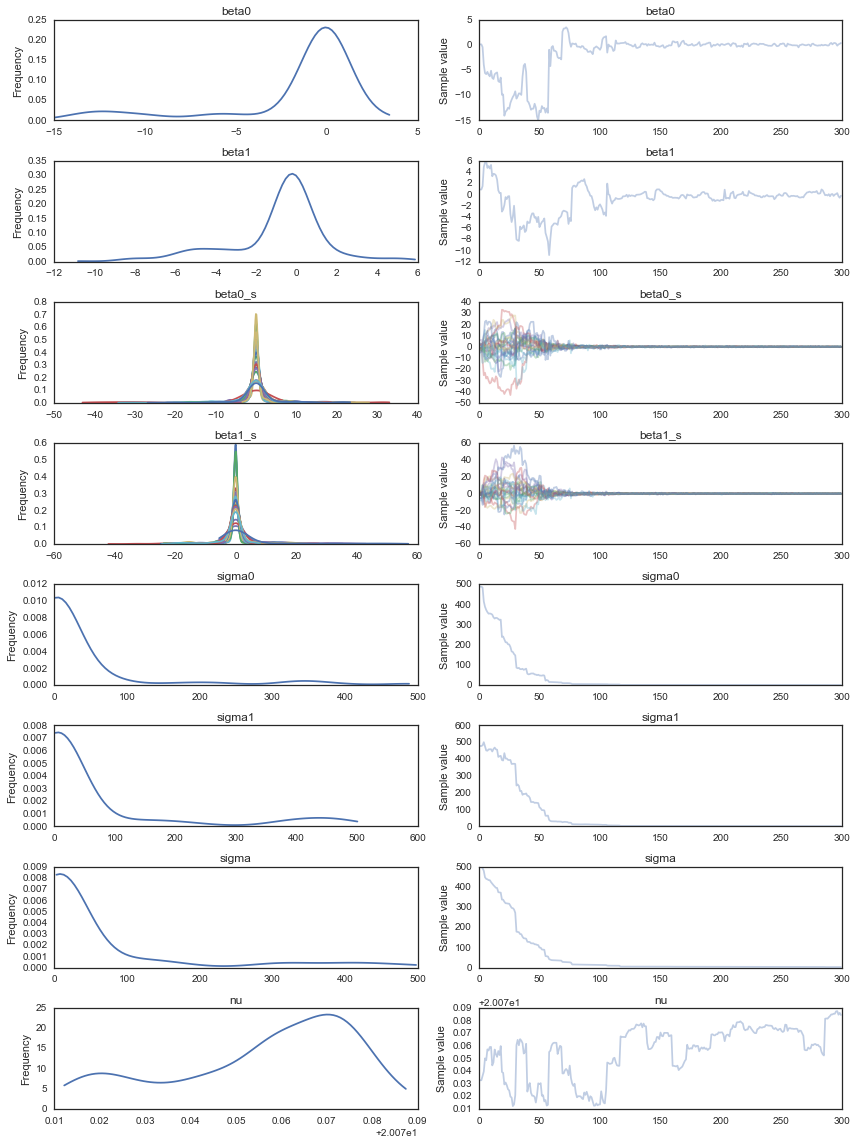

In [27]:
pmc.traceplot(trace3[:300]);

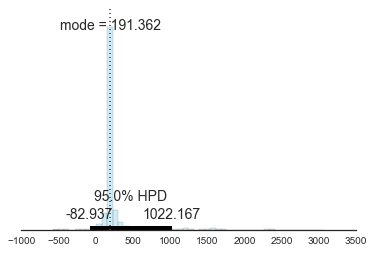

In [26]:
plot_posterior(trace3['beta1'][burnin:]*sd_y+mean_y-trace3['beta1'][burnin:]*mean_x*sd_y/sd_x);

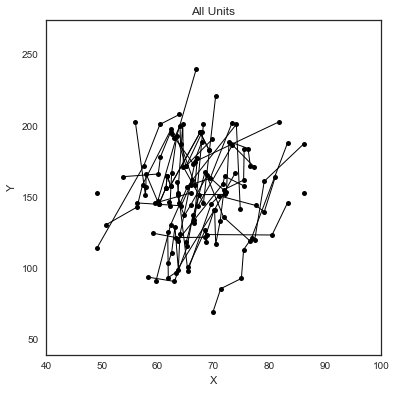

In [258]:
plt.figure(figsize=(6,6))
ax = plt.gca()

df_HRegr.groupby('Subj').apply(lambda group: ax.plot(group.X, group.Y, 'k-o', lw=1, markersize=5))
ax.set(xlabel='X', ylabel='Y', xlim=(40,100), ylim=(40,275), title='All Units');

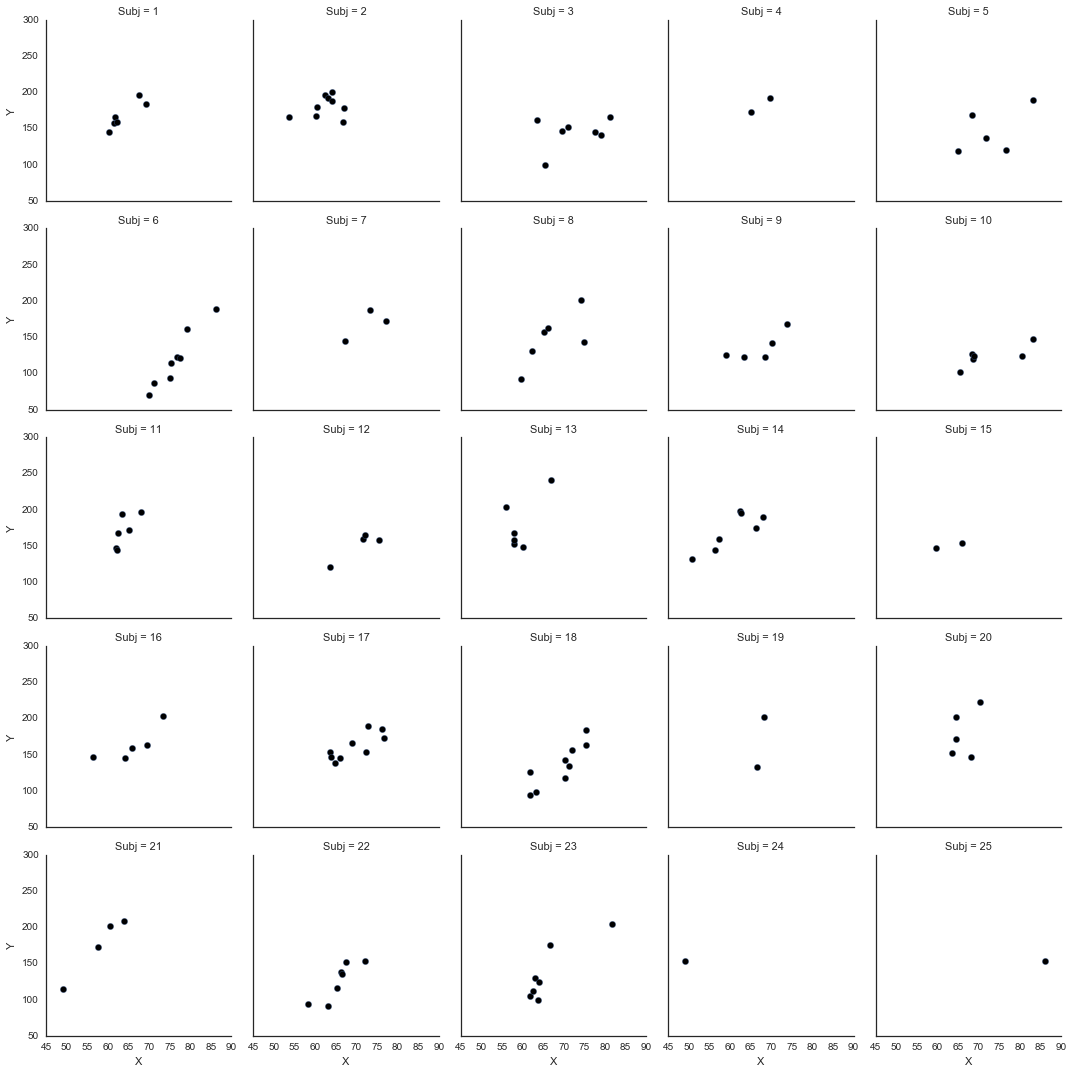

In [148]:
fg = sns.FacetGrid(df_HRegr, col='Subj', col_wrap=5)
fg.map(plt.scatter, 'X', 'Y', c='k', s=40);